# **Import Needed Modules**

In [72]:
import os
import time
import glob
import shutil

import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Create Needed Functions**

### **Function to create data**

In [73]:
# def create_data(data_dir):
#     image_paths = []
#     mask_paths = []
    
#     folds = sorted(os.listdir(data_dir))
#     for fold in folds:
#         foldpath = os.path.join(data_dir, fold)
#         if fold in ['image', 'Image', 'images', 'Images', 'IMAGES']:
#             images = sorted(os.listdir(foldpath))
#             for image in images:
#                 fpath = os.path.join(foldpath, image)
#                 image_paths.append(fpath)

#         elif fold in ['mask', 'Mask', 'masks', 'Masks', 'MASKS']:
#             masks = sorted(os.listdir(foldpath))
#             for mask in masks:
#                 fpath = os.path.join(foldpath, mask)
#                 mask_paths.append(fpath)
#         else:
#             continue
        
#     return image_paths, mask_paths

### **Functions to read images**

In [74]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    return images

### **Function to display data sample**

In [75]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_images(imgs, msks):
    plt.figure(figsize=(13,8))
    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')
    
    plt.tight_layout()
    plt.show()

### **Encoder**

In [76]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

### **Decoder**

In [77]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

### **AttentionGate**

In [78]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

### **Function to plot training history**

In [94]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_iou_metric']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Model Structure**

### **Get Data**

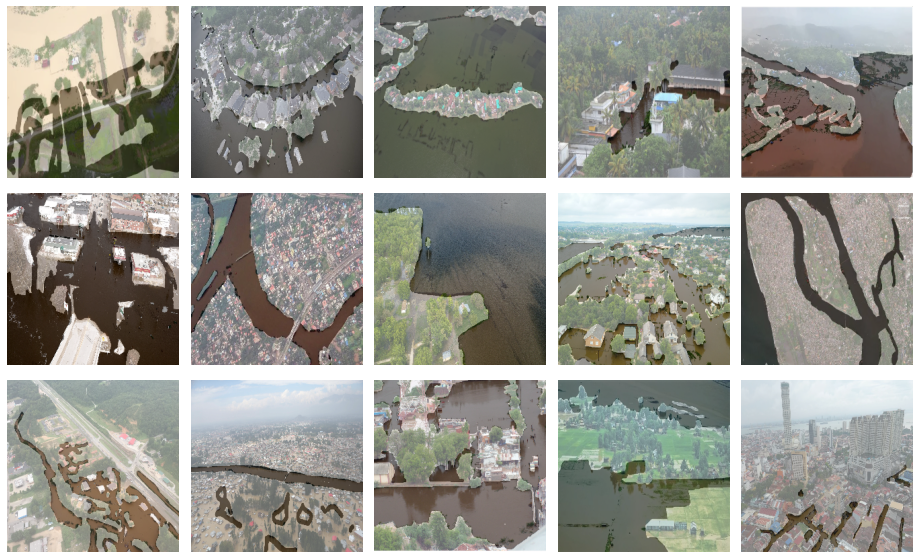

In [88]:
SIZE = 256
df = pd.read_csv("/kaggle/input/flood-dataset/Segmentation dataset/metadata.csv")
image_paths = ["/kaggle/input/flood-dataset/Segmentation dataset/Image/" + s for s in df["Image"].values]
mask_paths = ["/kaggle/input/flood-dataset/Segmentation dataset/Mask/" + s for s in df["Mask"].values]
# get data
# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)
# show sample
show_images(imgs, msks)

In [ ]:
input_layer = Input(shape= imgs.shape[-3:])

p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

model = Model(inputs = [input_layer], outputs= [output_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=['accuracy', iou_metric])

model.summary()

### **Create Model**

In [101]:
import keras
import numpy as np

class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        
    def on_epoch_end(self, epoch, logs=None):
        # Print the current epoch and its logs (like loss, accuracy, etc.)
        print(f'Epoch {epoch+1}/{self.epochs} ended.')
        print(f"Logs: {logs}")
        
        # If this is the `ask_epoch`, perform a custom task (e.g., asking user for input)
        if (epoch + 1) == self.ask_epoch:
            response = input(f"You're at epoch {epoch+1}. Continue training (yes/no)? ")
            if response.lower() == 'no':
                print('Training stopped by the user.')
                self.model.stop_training = True
            else:
                print('Continuing training.')

# Example usage
callbacks = [MyCallback(model=model, epochs=epochs, ask_epoch=ask_epoch)]


In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Intersection over Union (IoU) metric.

    Args:
        y_true (tensor): Ground truth labels (1D or 2D tensor).
        y_pred (tensor): Predicted labels (1D or 2D tensor).
        smooth (float): Smoothing term to avoid division by zero.

    Returns:
        tensor: IoU score.
    """
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

In [ ]:
import tensorflow as tf
def jaccard_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Jaccard loss (also known as Intersection over Union loss).

    Args:
        y_true (tensor): Ground truth labels (1D or 2D tensor).
        y_pred (tensor): Predicted labels (1D or 2D tensor).
        smooth (float): Smoothing term to avoid division by zero.

    Returns:
        tensor: Jaccard loss.
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    jaccard_index = (intersection + smooth) / (union + smooth)
    jaccard_loss = 1 - jaccard_index
    return jaccard_loss


In [ ]:
batch_size = 32     
epochs = 100        
ask_epoch = 5		    

### **Train Model**

In [ ]:
SPE = len(imgs)//batch_size
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=SPE,
    batch_size=batch_size
)

Epoch 1/100
9/9 [==============================] - 7s 490ms/step - loss: 0.6073 - accuracy: 0.4349 - iou_metric: 0.4034 - val_loss: 0.6677 - val_accuracy: 0.3198 - val_iou_metric: 0.3288
Epoch 2/100
9/9 [==============================] - 4s 417ms/step - loss: 0.5743 - accuracy: 0.4118 - iou_metric: 0.4287 - val_loss: 0.6677 - val_accuracy: 0.3198 - val_iou_metric: 0.3288
Epoch 3/100
9/9 [==============================] - 4s 418ms/step - loss: 0.5766 - accuracy: 0.4099 - iou_metric: 0.4239 - val_loss: 0.6677 - val_accuracy: 0.3198 - val_iou_metric: 0.3288
Epoch 4/100
9/9 [==============================] - 4s 417ms/step - loss: 0.5716 - accuracy: 0.4141 - iou_metric: 0.4257 - val_loss: 0.6677 - val_accuracy: 0.3198 - val_iou_metric: 0.3288
Epoch 5/100
9/9 [==============================] - 4s 417ms/step - loss: 0.5672 - accuracy: 0.4188 - iou_metric: 0.4307 - val_loss: 0.6677 - val_accuracy: 0.3198 - val_iou_metric: 0.3288
Epoch 6/100
9/9 [==============================] - 4s 418ms/step 

In [57]:
import tensorflow as tf
import os

def parse_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)  # Decode image in any format
        image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]

        # Resize if either height or width is less than 256
        image_shape = tf.shape(image)
        h, w = image_shape[0], image_shape[1]

        if tf.reduce_any(tf.less([h, w], 256)):
            new_h = tf.maximum(h, 256)
            new_w = tf.maximum(w, 256)
            image = tf.image.resize(image, [new_h, new_w])
        
        return image
    except Exception as e:
        print(f"Error parsing image {image_path}: {e}")
        return tf.zeros([256, 256, 3])  # Return a blank image as a placeholder

def parse_mask(mask_path):
    try:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_image(mask, channels=1)  # Decode mask in any format
        mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]

        # Resize if either height or width is less than 256
        mask_shape = tf.shape(mask)
        h, w = mask_shape[0], mask_shape[1]

        if tf.reduce_any(tf.less([h, w], 256)):
            mask = tf.image.resize(mask, [tf.maximum(h, 256), tf.maximum(w, 256)], method='nearest')
        
        return mask
    except Exception as e:
        print(f"Error parsing mask {mask_path}: {e}")
        return tf.zeros([256, 256, 1])  # Return a blank mask as a placeholder

def preprocess_image_and_mask(image, mask):
    combined = tf.concat([image, mask], axis=-1)
    combined = tf.image.random_crop(combined, size=[256, 256, 4])
    image = combined[..., :3]
    mask = combined[..., 3:]
    return image, mask

def load_and_preprocess_image_and_mask(image_path, mask_path):
    image = parse_image(image_path)
    mask = parse_mask(mask_path)
    image, mask = preprocess_image_and_mask(image, mask)
    return image, mask


# Iterate through the DataLoader


In [ ]:
i , m = load_and_preprocess_image_and_mask("/kaggle/input/flood-dataset/Segmentation dataset/Image/0.jpg","/kaggle/input/flood-dataset/Segmentation dataset/Mask/0.png")
print(i.shape,m.shape)
plt.imshow(i)

In [58]:
def create_tf_dataloader(image_paths, mask_paths, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img_path, msk_path: load_and_preprocess_image_and_mask(img_path, msk_path),
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Example usage

# Create DataLoader
batch_size = 8
dataloader = create_tf_dataloader(image_paths, mask_paths, batch_size=batch_size)


In [ ]:
for images, masks in dataloader:
    print(images[0].shape, masks[0].shape)  # Output: (batch_size, 256, 256, 3) and (batch_size, 256, 256, 1)


# **Evaluation**

In [ ]:
def get_image_paths(directory, extensions=('jpg', 'jpeg', 'png', 'bmp', 'tiff')):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Example usage
image_directory = '/kaggle/input/aqua-flood'
image_paths = get_image_paths(image_directory)
imgs = load_images(image_paths,SIZE = SIZE)
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(imgs))
        image = imgs[id]
        mask = msks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()